In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [156]:
df = pd.read_csv("C:/Users/sence/OneDrive/Masaüstü/PROJECT StrataScratch/2- Uber/datasets/dataset_1.csv")

In [157]:
df.head(10)

,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
0,10-Sep-12,7,5,0,2,2,9
1,NaN,8,6,0,2,2,14
2,NaN,9,8,3,0,0,14
3,NaN,10,9,2,0,1,14
4,NaN,11,11,1,4,4,11
5,NaN,12,12,0,2,2,11
6,NaN,13,9,1,0,0,9
7,NaN,14,12,1,0,0,9
8,NaN,15,11,2,1,2,7
9,NaN,16,11,2,3,4,6


In [158]:
df.columns = df.columns.str.strip()

In [159]:
# Fill missing date values forward
df['Date'] = df['Date'].fillna(method='ffill')

C:\Users\sence\AppData\Local\Temp\ipykernel_7916\462491804.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Date'] = df['Date'].fillna(method='ffill')


In [160]:
# Ensure 'Time (Local)' is a string and fill missing values
df['Time (Local)'] = df['Time (Local)'].astype(str).fillna('00:00')

In [161]:
# Normalize 'Time (Local)' to ensure it matches the format '%H:%M'
def normalize_time(time_str):
    parts = time_str.split(':')
    if len(parts) == 1:  # Only hour is given
        return f"{int(parts[0]):02d}:00"
    return f"{int(parts[0]):02d}:{int(parts[1]):02d}"

df['Time (Local)'] = df['Time (Local)'].apply(normalize_time)


In [162]:
# Remove extra spaces in column names
df.columns = df.columns.str.strip()


In [163]:
# Create timestamp column and set it as index
def create_timestamp(date, time):
    return pd.to_datetime(f"{date} {time}:00")

df['Timestamp'] = df.apply(lambda row: create_timestamp(row['Date'], row['Time (Local)']), axis=1)


In [164]:
# Ensure numeric columns are in numeric type
numeric_cols = ['Eyeballs', 'Zeroes', 'Completed Trips', 'Requests', 'Unique Drivers']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')


In [165]:
# Drop rows with any missing numeric values
df = df.dropna(subset=numeric_cols)

# Check data types
print(df.dtypes)


Date                       object
Time (Local)               object
Eyeballs                    int64
Zeroes                      int64
Completed Trips             int64
Requests                    int64
Unique Drivers              int64
Timestamp          datetime64[ns]
dtype: object


In [166]:
# Question 1: Which date had the most completed trips during the two-week period?
df_agg_date = df.groupby('Date')[numeric_cols].sum().reset_index()
most_completed_trips_date = df_agg_date.nlargest(1, 'Completed Trips')['Date'].values[0]
print("Most completed trips date:", most_completed_trips_date)

Most completed trips date: 22-Sep-12


In [167]:
df_agg_date.head()

,Date,Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
0,10-Sep-12,189,26,26,34,138
1,11-Sep-12,314,64,40,52,132
2,12-Sep-12,423,55,91,114,201
3,13-Sep-12,325,80,45,67,159
4,14-Sep-12,549,92,108,137,211


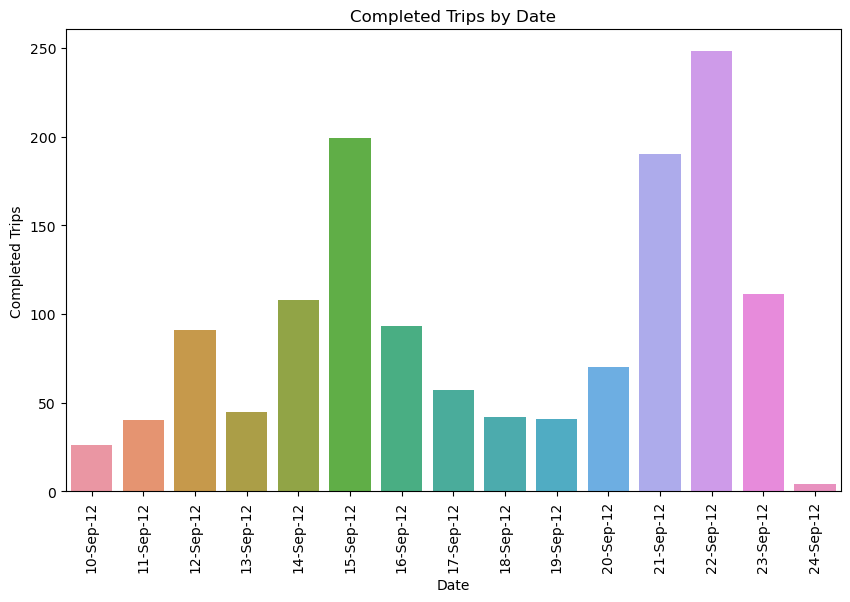

In [168]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Date', y='Completed Trips', data=df_agg_date)
plt.xticks(rotation=90)
plt.title('Completed Trips by Date')
plt.xlabel('Date')
plt.ylabel('Completed Trips')
plt.show()


In [169]:
# Question 2: What was the highest number of completed trips within a 24-hour period?
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=24)
df_numeric = df.set_index("Timestamp")[numeric_cols]
df_agg_twentyfour_hrs = df_numeric.rolling(window=indexer, min_periods=1).sum()
highest_completed_trips = df_agg_twentyfour_hrs.nlargest(1, 'Completed Trips')

time_format = "%Y/%m/%d %H:%M"
df_agg_twentyfour_hrs['Time Interval'] = df_agg_twentyfour_hrs.index.strftime(time_format) + "-" + (df_agg_twentyfour_hrs.index + pd.Timedelta('24 hours')).strftime(time_format)
completed_trips = highest_completed_trips['Completed Trips'].values[0]
time_interval = highest_completed_trips.index.strftime(time_format).values[0] + "-" + (highest_completed_trips.index + pd.Timedelta('24 hours')).strftime(time_format).values[0]

print("Number of completed trips:", completed_trips)
print("Time Interval:", time_interval)

Number of completed trips: 278.0
Time Interval: 2012/09/21 17:00-2012/09/22 17:00


In [170]:
df_agg_twentyfour_hrs.head()

,Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers,Time Interval
Timestamp,,,,,,
2012-09-10 07:00:00,212.0,38.0,29.0,39.0,150.0,2012/09/10 07:00-2012/09/11 07:00
2012-09-10 08:00:00,217.0,38.0,29.0,39.0,146.0,2012/09/10 08:00-2012/09/11 08:00
2012-09-10 09:00:00,222.0,40.0,27.0,37.0,138.0,2012/09/10 09:00-2012/09/11 09:00
2012-09-10 10:00:00,229.0,39.0,27.0,37.0,130.0,2012/09/10 10:00-2012/09/11 10:00
2012-09-10 11:00:00,232.0,38.0,28.0,37.0,124.0,2012/09/10 11:00-2012/09/11 11:00


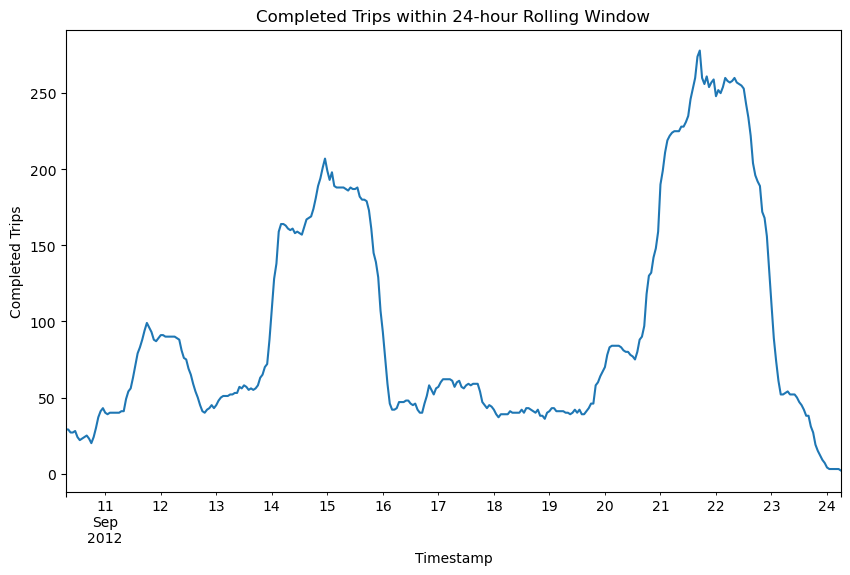

In [171]:
plt.figure(figsize=(10, 6))
df_agg_twentyfour_hrs['Completed Trips'].plot()
plt.title('Completed Trips within 24-hour Rolling Window')
plt.xlabel('Timestamp')
plt.ylabel('Completed Trips')
plt.show()

In [172]:
# Question 3: Which hour of the day had the most requests during the two-week period?
df_agg_time = df.groupby('Time (Local)')[numeric_cols].sum().reset_index()
most_requests_hour = df_agg_time.nlargest(1, 'Requests')['Time (Local)'].values[0]
print("Most requests hour:", most_requests_hour)

Most requests hour: 23:00


In [173]:
df_agg_time.head()

,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
0,00:00,339,81,102,142,111
1,01:00,207,43,71,96,94
2,02:00,170,52,61,100,62
3,03:00,83,30,21,35,40
4,04:00,29,21,2,9,9


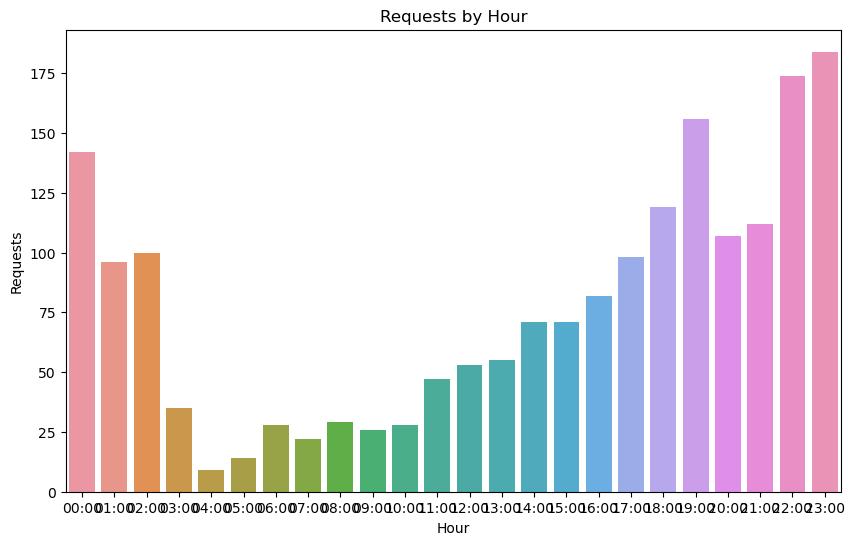

In [174]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Time (Local)', y='Requests', data=df_agg_time)
plt.title('Requests by Hour')
plt.xlabel('Hour')
plt.ylabel('Requests')
plt.show()


In [190]:
# Question 4: What percentage of all zeroes during the two-week period occurred on the weekend (Friday at 5 pm to Sunday at 3 am)?
total_zeroes = df['Zeroes'].sum()
df['Day'] = pd.to_datetime(df['Date']).dt.dayofweek
df['Hour'] = pd.to_datetime(df['Time (Local)'], format='%H:%M').dt.hour
weekend_zeroes = df[((df['Day'] == 4) & (df['Hour'] >= 17)) | (df['Day'] == 5) | ((df['Day'] == 6) & (df['Hour'] < 3))]['Zeroes'].sum()
weekend_zeroes_pct = weekend_zeroes / total_zeroes * 100
print("Weekend zeroes percentage:", weekend_zeroes_pct, '%')

Weekend zeroes percentage: 44.856543037088876 %


C:\Users\sence\AppData\Local\Temp\ipykernel_7916\53988145.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Day'] = pd.to_datetime(df['Date']).dt.dayofweek


In [176]:
df[['Date', 'Time (Local)', 'Zeroes']].head()

,Date,Time (Local),Zeroes
0,10-Sep-12,07:00,0
1,10-Sep-12,08:00,0
2,10-Sep-12,09:00,3
3,10-Sep-12,10:00,2
4,10-Sep-12,11:00,1


c:\Users\sence\anaconda3\lib\site-packages\seaborn\_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


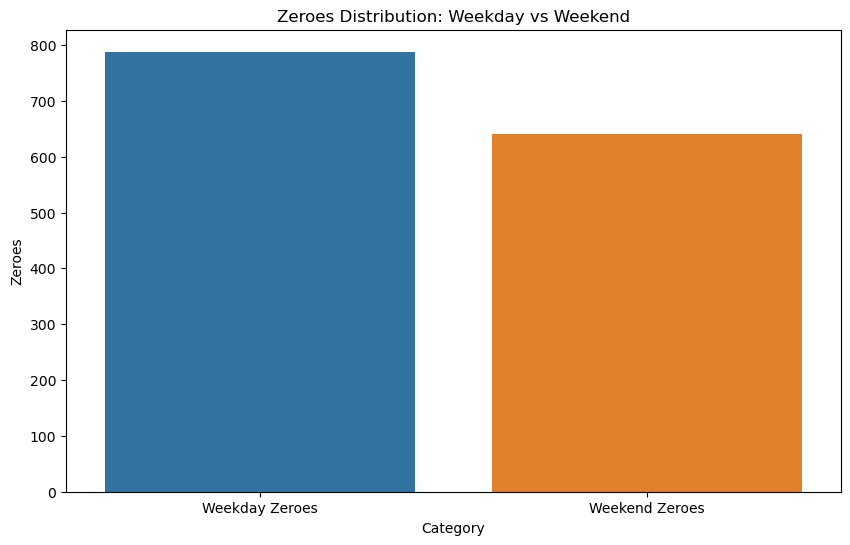

In [177]:
plt.figure(figsize=(10, 6))
sns.barplot(x=['Weekday Zeroes', 'Weekend Zeroes'], y=[total_zeroes - weekend_zeroes, weekend_zeroes])
plt.title('Zeroes Distribution: Weekday vs Weekend')
plt.xlabel('Category')
plt.ylabel('Zeroes')
plt.show()

In [178]:
# Question 5: What is the weighted average ratio of completed trips per driver during the two-week period?
df['completed_trip_ratio_per_driver'] = df['Completed Trips'] / df['Unique Drivers']
dataset_without_zero_unique_driver = df[df['Unique Drivers'] > 0]
weighted_average_ratio = np.average(dataset_without_zero_unique_driver['completed_trip_ratio_per_driver'], weights=dataset_without_zero_unique_driver['Completed Trips'])
print("Weighted average ratio of completed trips per driver:", weighted_average_ratio)


Weighted average ratio of completed trips per driver: 0.8282775715092395


In [179]:
dataset_without_zero_unique_driver[['completed_trip_ratio_per_driver']].head()

,completed_trip_ratio_per_driver
0,0.222222
1,0.142857
2,0.000000
3,0.000000
4,0.363636


In [180]:
# Question 6: In drafting a driver schedule in terms of 8 hours shifts, when are the busiest 8 consecutive hours over the two week period in terms of unique requests?
df_agg_eight_hrs = df.set_index("Timestamp").resample('8H')[numeric_cols].sum()
df_agg_eight_hrs['Time Interval'] = df_agg_eight_hrs.index.strftime(time_format) + "-" + (df_agg_eight_hrs.index + pd.Timedelta('8 hours')).strftime(time_format)
busiest_eight_hours = df_agg_eight_hrs.nlargest(1, 'Requests')
print("Busiest 8 consecutive hours:", busiest_eight_hours[['Time Interval', 'Requests']].values[0])


Busiest 8 consecutive hours: ['2012/09/21 16:00-2012/09/22 00:00' 192]


C:\Users\sence\AppData\Local\Temp\ipykernel_7916\2448642711.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_agg_eight_hrs = df.set_index("Timestamp").resample('8H')[numeric_cols].sum()


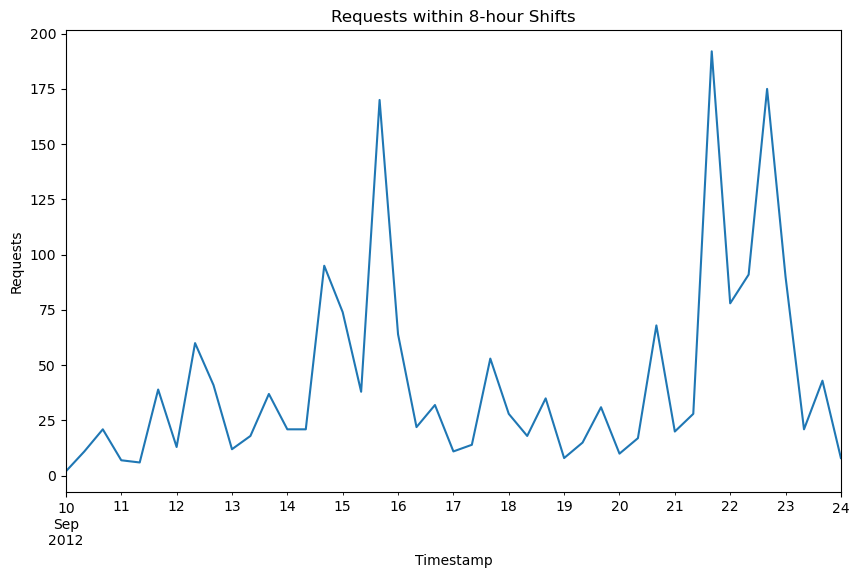

In [181]:
plt.figure(figsize=(10, 6))
df_agg_eight_hrs['Requests'].plot()
plt.title('Requests within 8-hour Shifts')
plt.xlabel('Timestamp')
plt.ylabel('Requests')
plt.show()


In [182]:
# Question 7: True or False: Driver supply always increases when demand increases during the two-week period.
df['request_diff'] = df['Requests'].diff().shift(-1)
df['supply_diff'] = df['Unique Drivers'].diff().shift(-1)
driver_supply_increases_with_demand = (df[df['request_diff'] > 0]['supply_diff'] > 0).all()
print("Driver supply always increases when demand increases:", driver_supply_increases_with_demand)


Driver supply always increases when demand increases: False


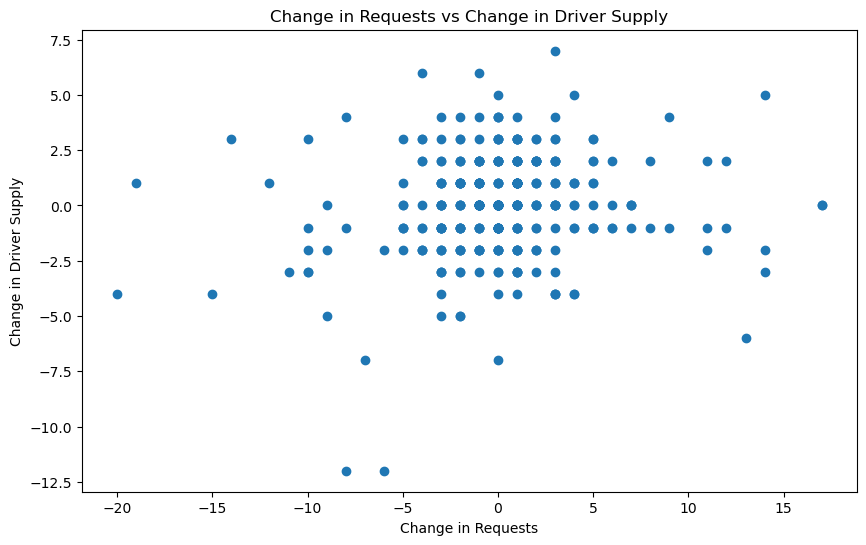

In [183]:
plt.figure(figsize=(10, 6))
plt.scatter(df['request_diff'], df['supply_diff'])
plt.title('Change in Requests vs Change in Driver Supply')
plt.xlabel('Change in Requests')
plt.ylabel('Change in Driver Supply')
plt.show()

In [184]:
# Question 8: In which 72-hour period is the ratio of Zeroes to Eyeballs the highest?
df_agg_seventy_two_hrs = df.set_index("Timestamp").rolling('72H')[numeric_cols].sum()
df_agg_seventy_two_hrs['zeroes_to_eyeballs_ratio'] = df_agg_seventy_two_hrs['Zeroes'] / df_agg_seventy_two_hrs['Eyeballs']
highest_zeroes_to_eyeballs_ratio = df_agg_seventy_two_hrs.nlargest(1, 'zeroes_to_eyeballs_ratio')
print("Highest zeroes to eyeballs ratio:", highest_zeroes_to_eyeballs_ratio['zeroes_to_eyeballs_ratio'].values[0])
print("Time Interval:", highest_zeroes_to_eyeballs_ratio.index.strftime(time_format).values[0] + "-" + (highest_zeroes_to_eyeballs_ratio.index + pd.Timedelta('72 hours')).strftime(time_format).values[0])


Highest zeroes to eyeballs ratio: 0.2929765886287625
Time Interval: 2012/09/18 04:00-2012/09/21 04:00


C:\Users\sence\AppData\Local\Temp\ipykernel_7916\3549906486.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_agg_seventy_two_hrs = df.set_index("Timestamp").rolling('72H')[numeric_cols].sum()


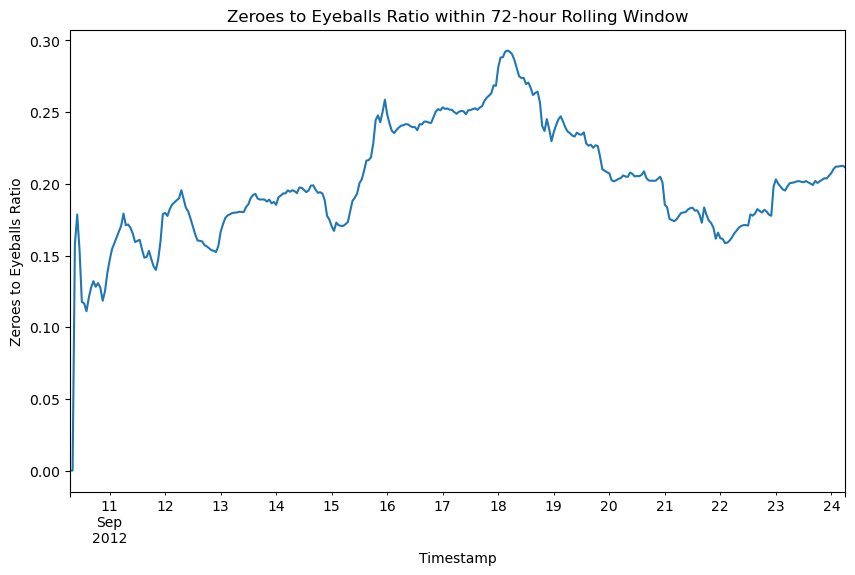

In [185]:
plt.figure(figsize=(10, 6))
df_agg_seventy_two_hrs['zeroes_to_eyeballs_ratio'].plot()
plt.title('Zeroes to Eyeballs Ratio within 72-hour Rolling Window')
plt.xlabel('Timestamp')
plt.ylabel('Zeroes to Eyeballs Ratio')
plt.show()

In [186]:
# Question 9: If you could add 5 drivers to any single hour of every day during the two-week period, which hour should you add them to?
highest_requests_hour = df.groupby('Time (Local)')[numeric_cols].sum().nlargest(1, 'Requests').index[0]
print("Best hour to add 5 drivers:", highest_requests_hour)


Best hour to add 5 drivers: 23:00


In [187]:
# Question 10: True or False: There is exactly two weeks of data in this analysis.
date_range = pd.to_datetime(df['Date'].unique())
date_range_length = (date_range.max() - date_range.min()).days
is_two_weeks_data = date_range_length == 14
print("There is exactly two weeks of data:", is_two_weeks_data)

There is exactly two weeks of data: True


C:\Users\sence\AppData\Local\Temp\ipykernel_7916\3573108306.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_range = pd.to_datetime(df['Date'].unique())


In [188]:
# Question 11: Looking at the data from all two weeks, which time might make the most sense to consider a true "end day" instead of midnight? (i.e., when are supply and demand at both their natural minimums)
supply_demand = df.groupby('Time (Local)')[['Requests', 'Unique Drivers']].sum()
supply_demand_minimum = supply_demand.sum(axis=1).idxmin()
print("Most logical end day time:", supply_demand_minimum)

Most logical end day time: 04:00


<Figure size 1000x600 with 0 Axes>

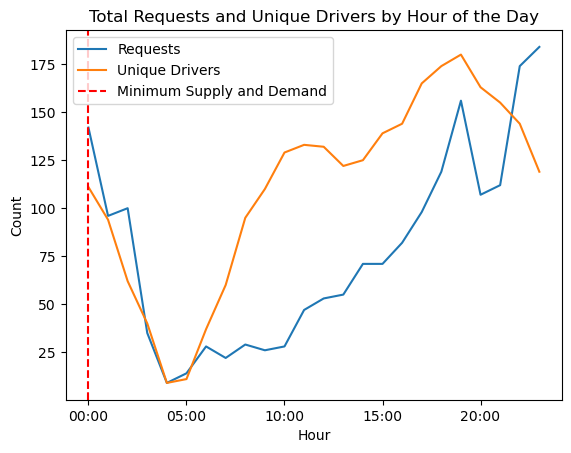

In [189]:
plt.figure(figsize=(10, 6))
supply_demand.plot()
plt.axvline(x=supply_demand_minimum, color='red', linestyle='--')
plt.title('Total Requests and Unique Drivers by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.legend(['Requests', 'Unique Drivers', 'Minimum Supply and Demand'])
plt.show()